## Start by copying this into your Google Drive!!

Maastricht_University_logo.svg

# Advanced Natural Language Processing Course - Tutorial Measuring Quality
Author: Gijs Wijngaard




Welcome to the tutorial on measuring quality. 


The first step is to **enable GPU**. A GPU is a Graphical Processing Unit, capable of calculating vectors and matrices much faster than CPU units, like the one in your laptop. Since neural networks are basically made out of matrices, we gain serious speed improvements by using GPU's. 

We enable the GPU by clicking on *Runtime* in the menu above, then click *Change runtime type* and on the dropdown menu under *Hardware accelerator* we click *GPU*. Then click *Save*. If everything is correct, the below code should return *True*

---

## Measuring Output Quality of a Classification Model
We start with training a machine learning model first. We train a Transformers model on the most popular benchmark in natural language processing, named GLUE. This benchmark and its successor SuperGLUE are used in NLP research a lot to compare models to each other. Its a way for any model to test it if is performing well or not. You can find the benchmark [here](https://gluebenchmark.com/) and its [successor](https://super.gluebenchmark.com/) here. We are going to use one of its datasets as a task for our model to train on. Lets install some packages first:

In [ ]:
!pip install -qq transformers datasets

     |████████████████████████████████| 5.5 MB 14.6 MB/s 
     |████████████████████████████████| 441 kB 64.4 MB/s 
     |████████████████████████████████| 7.6 MB 55.0 MB/s 
     |████████████████████████████████| 163 kB 69.9 MB/s 
     |████████████████████████████████| 212 kB 52.8 MB/s 
     |████████████████████████████████| 95 kB 5.8 MB/s 
     |████████████████████████████████| 115 kB 76.5 MB/s 
     |████████████████████████████████| 127 kB 67.9 MB/s 
     |████████████████████████████████| 115 kB 65.3 MB/s 


GLUE consists of 11 datasets. Today, we will focus on only one of these, the Corpus of Linguistic Acceptability. This dataset is a dataset to test whether a model can recognize whether a sentence is actual English, or contains some spelling or grammatical mistakes. Lets import it:

In [ ]:
from datasets import load_dataset
data = load_dataset("glue", "cola")

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Lets display how our data looks like. This is a example of a correct sentence in our dataset (label = 1)

In [ ]:
data["train"][0]

{'sentence': "Our friends won't buy this analysis, let alone the next one we propose.",
 'label': 1,
 'idx': 0}

Hereunder is an example of an incorrect sentence in our dataset (label = 0). You can't drink a pub right? That is for the model to recognize, can it find sentences that are incorrect.

In [ ]:
data["train"][18]

{'sentence': 'They drank the pub.', 'label': 0, 'idx': 18}

Lets now import our model. This is the first time we work with transformers models. Transformers is a library by HuggingFace. When working with transformer-based models, its one of the most convenient tools you can have. It supports all types of different trasnformer models, and you can download pretrained models from the transformers library to apply it to your own data. Normally, transformer models work well when trained on large datasets. With pretrained models, these models are already trained on large datasets thus do not need to be trained again. Its handy for applying state-of-the-art models on any problem you have.

Let's use the most standard transformer model, that of BERT. We can use BERT for a variety of tasks, this time we will use it for sequence classification.  In a later lecture you will learn more about BERT and its applications. For our task, we want to know whether our data (which is a sequence) is a right english sentence or not (binary classification task).
We also use `.to(device)` method to speed things up. If you don't want to wait long when predicting outputs using transformers, make sure you are on GPU in colab.

You can ignore the warnings starting with `Some weights ...`, they are just for letting you know what you can do with the model.

In [ ]:
from sklearn import metrics
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased").to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Lets train our model first. We first define a dataloader. This function is used so that we can have large batches (`batch_size=16` in this case) and process multiple data inputs at once. This even speeds up the computation more. We first nullify our gradients. We put the data through the tokenizer, so that we get numbers instead of texts. Also an `attention_mask` is received from our tokenizer, so that our transformer model knows which part of the data to focus on: we pad the data to let it fit through the model. As model input, we feed the output of the tokenizer and a label, so that the model can compute a loss that defines how close we are to the label. We then backpropagate.

In [ ]:
losses = []
train_dataloader = torch.utils.data.DataLoader(data["train"], batch_size=16)
for item in tqdm(train_dataloader):
    model.zero_grad()
    inputs = tokenizer(item["sentence"], padding=True, return_tensors="pt").to(device)
    result = model(**inputs, labels=item["label"].to(device))
    loss = result.loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 535/535 [00:56<00:00,  9.49it/s]


Lets now define a simple prediction function. Remember, always train on a training set, and test your model on a validation set. 

We don't want to compute gradients, since we will not backpropagate the data (`torch.no_grad()`). We get the logits and move that onto the cpu with `.cpu().numpy()`.

In [ ]:
val_dataloader = torch.utils.data.DataLoader(data["validation"], batch_size=16)
results = []
for item in tqdm(val_dataloader):
    inputs = tokenizer(item["sentence"], padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    results.append(logits.argmax(dim=-1).cpu().numpy())
results = [result for result_array in results for result in result_array]

100%|██████████| 66/66 [00:01<00:00, 41.85it/s]


These are our true values: The actual correct values of the validation set 

In [ ]:
val_labels = [data["label"] for data in data["validation"]]

We again can use the `accuracy_score` function from `scikit-learn`. This function predicts for us the `accuracy`: how many true positives and true negatives devided by all predictions we have.

In [ ]:
metrics.accuracy_score(val_labels, results)

0.788111217641419

We also can plot a confusion matrix with `scikit-learn`. These values correspond to each of the 4 sectors. True positives,  true negatives, false positives, false negatives.

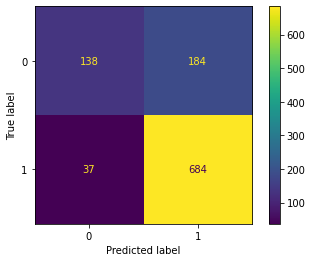

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(val_labels, results)

We can get the individual values using sklearn's `confusion_matrix`:

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(val_labels, results).ravel()
tn

138

In [ ]:
fn

In [ ]:
tp

### Exercise 1.1
> 1. Compute the following metrics by hand: $$Precision = \frac{TP}{TP+FP}\quad Recall = \frac{TP}{(TP+FN)} \quad Accuracy = \frac{TP + TN}{TP + TN + FP + FN} \quad F1 = 2 * \frac{Precision * Recall}{Precision + Recall}$$ using the variables `tn`, `fp`, `fn`, `tp` above. 
2. Why is `accuracy` not a good metric for this dataset?

In [ ]:
# COMPUTE PRECISION, RECALL, ACCURACY AND F1 HERE
P=tp/(tp+fp)
print(P)
R=tp/(tp+fn)
print(R)
Acc=(tp+tn)/(tp+tn+fp+fn)
print(Acc)
F1=(2*P*R)/(P+R)
print(F1)

precision=0.7851335656213705 ,
recall=0.9375866851595007 ,
Accuracy=0.7794822627037392 ,
F1 score=0.8546144121365361 


Accuracy is not a good metric for this dataset because data here are **imballanced**.
The class with the label=1 prevails with 721 data, whereas class with label=0 has only 322 data.




### Exercise 1.2
> 1. When do we prefer precision? 
2. When do we prefer recall? 
3. Give an examples of datasets that you could encounter where you would prefer one over the other.

Precision and recall are used for both balanced and imballanced data.
Precision measures the "quality" of prediction, while recall the "quantity" of  prediction(it is a measure of how many relevant elements were detected).Precision is prevered over recall when we need high true positives.Precision is how good the model is at predicting a specific category. Recall tells you how many times the model was able to detect a specific category.Precision:Correct positive predictions relative to total positive predictions.Recall:Correct positive predictions relative to total actual positives.


Precision is used in marketing campaigns.For example if a company is interested to produce a new product it is important to know if the customers are going to buy this product and so the company needs a model that will predict succesfully the class of those who will buy it.(given some information about the customers..for instance how often they eat cheese,if they prefer big or small package etc)

Recall could be used in a dataset where we need to predict a class as often as possible(for instance for fraud detection is very important to predict as many fraud cases as possible)


### Exercise 1.3
> 1. Now also compute $F0.5$ and $F2$ metrics. 
2. How do these compare to the $F1$ metric?

ANSWER HERE

In [ ]:
# COMPUTE F0.5 and F2 metrics here
F05=((0.5**2+1)*P*R)/(0.5**2*P+R)
print(F05)
F2=((2**2+1)*P*R)/(2**2*P+R)
print(F2)

F0.5 < F1 < F2
In F1 score the recall and precision are of the same importance.
F0.5 and F2(generally Fβ) measures allow us to define how much the recall is important than the precision.
As F2 is bigger than F0.5 we can conlude that recall is more useful in this dataset as for β>1 recall is prefered than precision.

### Exercise 1.4
> Instead of using `accuracy`, the GLUE benchmark uses a different metric for this dataset, Matthews correlation coefficient (also known as the Phi coefficient). $$MCC = \frac{TP \times TN - FP\times FN}{\sqrt{(TP+FP)\times(TP+FN)\times(TN+FP)\times(TN+FN)}}$$ When computing this coefficient, we should get a value between 1 and -1, where 1 is a perfect prediction, 0 a random prediction and -1 a inverse prediction. Now compute also the MCC:

In [ ]:
# COMPUTE MCC HERE
import math
MCC=(tp*tn-(fp*fn))/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
MCC


## Using Model's probabilities
We now computed some metrics using the predictions of the model: whether the model thinks its correct or incorrect. To calculate this, we took the `argmax()` of the logits. Let's focus one more time on what we did.

In [ ]:
inputs = tokenizer(next(iter(val_dataloader))["sentence"], padding=True, return_tensors="pt").to(device)
with torch.no_grad():
    logits = model(**inputs).logits
logits = logits.cpu().detach()

We used these logits and for every pair of two we took whatever value is the highest (`argmax()`). Now we can also take the softmax, this then converts our values to make them sum together to 1 per prediction:

In [ ]:
logits.softmax(dim=-1)

tensor([[0.0481, 0.9519],
        [0.0451, 0.9549],
        [0.0635, 0.9365],
        [0.1171, 0.8829],
        [0.1845, 0.8155],
        [0.1431, 0.8569],
        [0.1681, 0.8319],
        [0.1829, 0.8171],
        [0.0909, 0.9091],
        [0.1030, 0.8970],
        [0.2194, 0.7806],
        [0.2855, 0.7145],
        [0.0713, 0.9287],
        [0.7199, 0.2801],
        [0.0810, 0.9190],
        [0.1924, 0.8076]])

As you can see, we now have a percentage per prediction of how sure the model is about that prediction, the the first value being the sentence is incorrect, the second value the sentence being correct. Lets now only take the last value of each prediction: we only need the chance that a value belongs to 1, if its higher than 50% probability it belongs so, if lower, it belongs to 0.

In [ ]:
percentage = logits.softmax(dim=-1)[:, -1]

In [ ]:
percentage

tensor([0.9519, 0.9549, 0.9365, 0.8829, 0.8155, 0.8569, 0.8319, 0.8171, 0.9091,
        0.8970, 0.7806, 0.7145, 0.9287, 0.2801, 0.9190, 0.8076])

Lets collect the percentages for the whole validation dataset, and plot the precision-recall curve:

In [ ]:
percentages = []
for item in tqdm(val_dataloader):
    inputs = tokenizer(item["sentence"], padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    percentages.append(logits.softmax(dim=-1)[:, -1].cpu().numpy())
percentages = np.array([result for result_array in percentages for result in result_array])

100%|██████████| 66/66 [00:01<00:00, 41.15it/s]


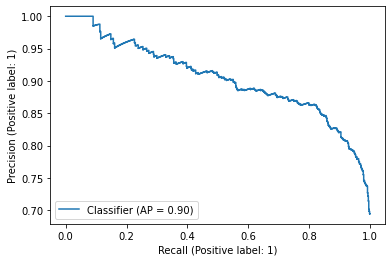

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt 
PrecisionRecallDisplay.from_predictions(val_labels, percentages)

Lets go over how this graph is calculated. On each step in the graph, we change the probability boundary, to get a different precision and recall value (also can be applied to TPR and FPR in ROC/AUC graphs) For example, normally we would just take 50% as boundary. All values that are above 0.5 are counted as being 1, all values below 0.5 are counted to 0. So these indices are predicted as false:

In [ ]:
np.where(percentages < 0.5)

(array([  13,   23,   34,   41,   44,   45,   65,   73,   76,   80,   83,
          86,   91,  125,  129,  146,  155,  165,  170,  175,  190,  191,
         192,  193,  196,  201,  212,  217,  224,  225,  226,  229,  236,
         246,  255,  257,  269,  271,  278,  281,  298,  329,  332,  335,
         338,  342,  344,  350,  353,  354,  362,  365,  372,  382,  384,
         386,  387,  390,  391,  392,  393,  394,  398,  407,  408,  415,
         428,  432,  433,  436,  437,  450,  451,  453,  455,  457,  458,
         459,  469,  471,  472,  475,  478,  494,  496,  497,  500,  501,
         504,  509,  512,  519,  520,  521,  522,  524,  580,  613,  614,
         618,  620,  622,  624,  625,  637,  676,  692,  693,  695,  700,
         702,  707,  709,  714,  720,  728,  729,  730,  731,  733,  738,
         740,  741,  751,  787,  788,  807,  809,  810,  813,  818,  819,
         823,  828,  832,  836,  840,  848,  850,  852,  860,  868,  870,
         887,  889,  906,  907,  911, 

In [ ]:
indices = np.where(percentages < 0.5, 0, 1)
print(metrics.precision_score(val_labels, indices))
print(metrics.recall_score(val_labels, indices))

0.7880184331797235
0.9486823855755895


Notice that this decision boundary is set to 0.5 with `np.where()`, we can change that to 0.9 or 0.4 or anything else.

In [ ]:
indices = np.where(percentages < 0.8, 0, 1)
print(metrics.precision_score(val_labels, indices))
print(metrics.recall_score(val_labels, indices))

0.8559201141226819
0.8321775312066574


With the default 0.5 decision boundary, we get a somewhat high `precision`, but our `recall` is still low. Sometimes, we want one over the other, thus it makes sense to change the decision boundary. Say when you want to model to be absolutely sure about its predictions, you could then state that you only allow prediction values higher than 0.9 to be accepted (as 1) and the rest is 0.

Lets compute the values for this precision recall curve, we can also get the thresholds for this curve, so we know at which values the precision and recall was calculated (remember the threshold is our boundary). The amount of threshold values is equal to the number of unique percentages we have calculated from our dataset, e.g. `len(np.unique(percentages))`. By default we calculate the precision and recall for these thresholds, when calculating them for the graph above:

In [ ]:
precision, recall, thresholds = metrics.precision_recall_curve(val_labels, percentages)
thresholds

array([0.16431135, 0.16461429, 0.1656304 , ..., 0.9662476 , 0.9663168 ,
       0.9676601 ], dtype=float32)

In [ ]:
len(precision)

1034

### Exercise 2
Let's make an averaged 11-point precision recall graph (similar to the precision recall graph above, but now with only 11 points) , as explained in the lecture, and plot this below. For a refresher, [check here](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-ranked-retrieval-results-1.html). You can use the [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) and [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) functions from scikit-learn.

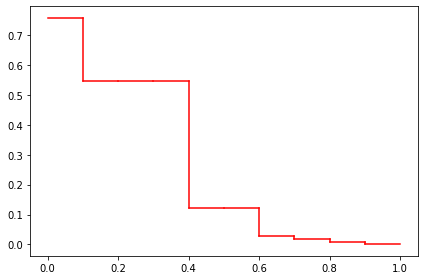

0.3143646839453633


In [ ]:
# ANSWER HERE
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.autolayout"] = True
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
precision, recall,thresholds  = metrics.precision_recall_curve(val_labels, percentages)
average_precision = average_precision_score(val_labels, percentages)
recall = np.linspace(0.0, 1.0, num=11)
precision = np.random.rand(11)*(1.-recall)
i=recall.shape[0]-2
while i>=0:
  if precision[i+1]>precision[i]:
    precision[i]=precision[i+1]
  i=i-1
fig, ax = plt.subplots()
for i in range(recall.shape[0]-1):
    ax.plot((recall[i],recall[i]),(precision[i],precision[i+1]),'k-',label='',color='red') 
    ax.plot((recall[i],recall[i+1]),(precision[i+1],precision[i+1]),'k-',label='',color='red')
plt.show()


# AveragePrecision = 1/11 * Sum(11 point interpolated precision)
intpre=0
for i in range(0,11):
  intpre=intpre+precision[i] 
avgpr= 1/11*intpre
print(avgpr)
#The idea of the 11-point interpolated average precision is to average the precisions at a
#set of 11 recall levels (0,0.1,...,1). The interpolated precision values are obtained by taking 
#the maximum precision whose recall value is greater than its current recall value .

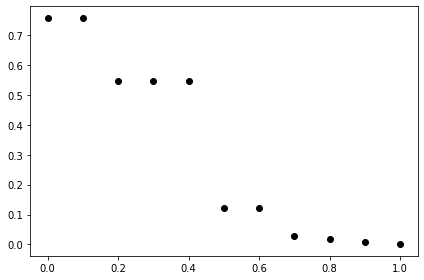

In [ ]:
for i in range(0,11):
  plt.plot(recall[i], precision[i] , 'o', color='black');
plt.show() 

## Metrics in Machine Translation

We now continue to work with machine translation models. We again work with `transformers` pretrained models. This time we work on a translation dataset, that from news articles that are from 2 languages. We ask the model to translate from Dutch to English, and then we test how good the model performs. Don't worry if you don't know Dutch! You do not need to. 

Lets import the model first and split the data up in training and test sets.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("opus_books", "en-nl")
dataset = dataset["train"].train_test_split(test_size=0.2)

Generating train split:   0%|          | 0/38652 [00:00<?, ? examples/s]

Dataset opus_books downloaded and prepared to /root/.cache/huggingface/datasets/opus_books/en-nl/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Lets check our dataset.

In [ ]:
dataset["train"][0]["translation"]

{'en': 'How can you be so cross as not to come? Why they are your cousins, you know, after a fashion.',
 'nl': "Hoe kan je nu zoo onaardig zijn, om niet te komen! 't Zijn toch ook nichtjes van jelui, in zekeren zin."}

Alright, lets import an encoder-decoder model. In a later Colab in Course 8 of Advanced Natural Language Processing you will also work on Machine Translation, now we just want you to focus on computing the metrics for these notebooks, namely BLEU and METEOR. 

Down here we define a encoder-decoder model `t5-small`. We preprocess the input of these models so that it has a prompt, we can steer the model to come up with a solution then. We tokenize the input, truncate texts that are longer than 256 tokens, and batch them.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small").to(device)
prefix = "translate Dutch to English: "
def preprocess_function(example):
    return tokenizer(prefix + example["translation"]["nl"], text_target=example["translation"]["en"], max_length=256, truncation=True)
train_data = dataset["train"].map(preprocess_function, remove_columns=["id", "translation"])
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

  0%|          | 0/30921 [00:00<?, ?ex/s]

We put the data in a dataloader, which allows us for faster processing, we define an optimizer to train our model. The following code, for 1 epoch, takes about 10 minutes to train. Please make sure you are on a GPU (check instructions at the beginning of this notebook), else it will take longer! 

In [ ]:
print(device)

cuda


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, collate_fn=data_collator)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

for epoch in range(1):
    for item in tqdm(train_dataloader):
        model.zero_grad()
        loss = model.forward(**item.to(device)).loss
        loss.backward()
        optimizer.step()

100%|██████████| 967/967 [10:20<00:00,  1.56it/s]


We now take the test dataset and do exactly the same, this time we ask the model to come up with the english string he thinks is the translation of the dutch string.

In [ ]:
def preprocess_test_function(example):
    return tokenizer(prefix + example["translation"]["nl"], max_length=256, truncation=True)
test_data = dataset["test"].map(preprocess_test_function, remove_columns=["id", "translation"])
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, collate_fn=data_collator)

  0%|          | 0/7731 [00:00<?, ?ex/s]

We let the model generate the english strings and then decode the output tokens back to strings with `batch_decode()`, we skip special tokens in this decoding process that are needed for generation.

In [ ]:
outputs = []
for item in tqdm(test_dataloader):
    output = model.generate(**item.to(device))
    outputs.append(output)
translation_results = tokenizer.batch_decode([x for y in outputs for x in y], skip_special_tokens=True)

  0%|          | 0/242 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,
100%|██████████| 242/242 [01:17<00:00,  3.13it/s]


Lets see what the results looks like!

In [ ]:
print(translation_results[:5])
my_tr=' '
for x in translation_results[:5]:
   my_tr += ''+ x
print(my_tr)

['Then, in the morning, the gids gathered in the midst', 'Tom wierp de massa shook his head and shook his head:', 'Then, as if I had a solitary solitary, I would', '"It is a great thing," I said, "do you know what you', 'He sat down with his ear.']
 Then, in the morning, the gids gathered in the midstTom wierp de massa shook his head and shook his head:Then, as if I had a solitary solitary, I would"It is a great thing," I said, "do you know what youHe sat down with his ear.


And now lets see what the original sentences look like (the ones the model should come close to when predicting):

In [ ]:
references = [data["translation"]["en"] for data in dataset["test"]]
references[:5]

['The journey was resumed at six in the morning; the guide hoped to reach Allahabad by evening.',
 'Tom poured the mass of yellow coin upon the table and said: "There--what did I tell you?',
 'In short, a thousand questions I had no time to answer.',
 '"But rest assured," I added, "that between passengers, seamen, or officers, we don\'t total one-tenth of that figure."',
 'He came to them every day.']

In [ ]:
 my_ref=''
 for x in references[:5]:
     my_ref += ''+ x
print(my_ref)

The journey was resumed at six in the morning; the guide hoped to reach Allahabad by evening.Tom poured the mass of yellow coin upon the table and said: "There--what did I tell you?In short, a thousand questions I had no time to answer."But rest assured," I added, "that between passengers, seamen, or officers, we don't total one-tenth of that figure."He came to them every day.


Hmm, It looks like its far of, but some words are there at least. Now, how do we know for sure the model is performing correctly/incorrectly? We need a metric!

## Bilingual Evaluation Understudy (BLEU)
BLEU is a good way to test how good these models perform. Normally you would just import a bleu metric from packages such as `NLTK` or `torchtext` and calcuate the score, but we are going to do it by hand (fun!). Lets implement $BLEU_1$, which means we focus ourselves on only unigrams (single words).

Our candidate sentences are defined in `results`. Our reference sentences are defined in `references`. 

We iterate over the results and references, and compute on each iteration for both result and reference the ngrams. We do this by counting the words/tokens in the sentence. 


### Exercise 3
> 1. Implement the BLEU score yourself, by using the formulas from [wikipedia](https://en.wikipedia.org/wiki/BLEU) or the slides. 
2. Apply the BLEU score on one of the references and candidates to see if your implementation works.


In [ ]:
# WRITE BLEU SCORE HERE


In [ ]:
def n_gram_generator(sentence,n,n_gram= False):
    sentence = sentence.lower() # converting to lower case
    sent_arr = np.array(sentence.split()) # split to string arrays
    length = len(sent_arr)

    word_list = []
    for i in range(length+1):
        if i < n:
            continue
        word_range = list(range(i-n,i))
        s_list = sent_arr[word_range]
        string = ' '.join(s_list) # converting list to strings
        word_list.append(string) # append to word_list
        if n_gram:
            word_list = list(set(word_list))
    return word_list

In [ ]:
n_gram_generator(my_ref,1,n_gram= False)

['the',
 'journey',
 'was',
 'resumed',
 'at',
 'six',
 'in',
 'the',
 'morning;',
 'the',
 'guide',
 'hoped',
 'to',
 'reach',
 'allahabad',
 'by',
 'evening.tom',
 'poured',
 'the',
 'mass',
 'of',
 'yellow',
 'coin',
 'upon',
 'the',
 'table',
 'and',
 'said:',
 '"there--what',
 'did',
 'i',
 'tell',
 'you?in',
 'short,',
 'a',
 'thousand',
 'questions',
 'i',
 'had',
 'no',
 'time',
 'to',
 'answer."but',
 'rest',
 'assured,"',
 'i',
 'added,',
 '"that',
 'between',
 'passengers,',
 'seamen,',
 'or',
 'officers,',
 'we',
 "don't",
 'total',
 'one-tenth',
 'of',
 'that',
 'figure."he',
 'came',
 'to',
 'them',
 'every',
 'day.']

In [ ]:
def bleu_score(original,machine_translated):
    mt_length = len(machine_translated.split())
    o_length = len(original.split())

    # Brevity Penalty 
    if mt_length>o_length:
        BP=1
    else:
        penality=1-(mt_length/o_length)
        BP=np.exp(penality)

    # Clipped precision
    clipped_precision_score = []
    for i in range(1, 5):
        original_n_gram = Counter(n_gram_generator(original,i))
        machine_n_gram = Counter(n_gram_generator(machine_translated,i))

        c = sum(machine_n_gram.values())
        for j in machine_n_gram:
            if j in original_n_gram:
                if machine_n_gram[j] > original_n_gram[j]:
                    machine_n_gram[j] = original_n_gram[j]
            else:
                machine_n_gram[j] = 0

        #print (sum(machine_n_gram.values()), c)
        clipped_precision_score.append(sum(machine_n_gram.values())/c)

    #print (clipped_precision_score)

    weights =[1]

    s = (w_i * math.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))
    s = BP * math.exp(math.fsum(s))
    return s

In [ ]:
import math
from math import log
from nltk.translate.bleu_score import sentence_bleu
from collections import Counter
original = my_ref
machine_translated = my_tr
print(bleu_score(my_ref,my_tr))
print(sentence_bleu([original.split()], machine_translated.split(),weights=(1, 0, 0, 0)))

0.30228497247001335
0.14248453076221212


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


## Language Model Evaluation

We can also know how good our model performs by calculating the perplexity. For an encoder-decoder model, the model is trained on a cross entropy loss, so we just do:

In [ ]:
perplexity = torch.exp(loss)
perplexity.item()

### Exercise 4
> 1. Research what perplexity is, and if our score above is good or not. 
2. Are there also other metrics or ways how we can measure language models?

Perplexity is a measurement of
how well a probability distribution or probability model
predicts a sample.Perplexity can be also used to compare probability models.Low perplexity means better model.

The perplexity in our model here is about 26 which means that the model is as confused on test data as if it had to choose uniformly and independently among 26 possibilities for each word.Our score is good because is quite low.

There are also other evaluation metrics for language models such as cross entropy and beats per charachter(BPC).




#Submission
Please share your Colab notebook by clicking File on the top-left corner. Click under Download on Download .ipynb and upload that file to Canvas.